# 개와 고양이 데이터 세트의 디렉토리와 파일을 기반으로 메타 정보용 DataFrame 생성

In [54]:
# from google.colab import drive
# drive.mount('/gdrive', force_remount=True)
# !gdown --id 1MP5IVX30XcYqN5RHwBKPdWLEvRfXLH71

In [55]:
# !unzip catanddog.zip
# !rm -r test_set training_set

In [56]:
import numpy as np
import pandas as pd
import os

In [57]:
# 데이타프레임 생성 함수
# os.walk()를 이용하여 특정 디렉토리 밑에 있는 모든 하위 디렉토리를 읽는다.
# 해당 디렉토리의 jpg 확장자를 가진 모든 파일 읽기
def make_catndog_dataframe():
  paths = []
  dataset_gubnus = []
  label_gubuns = []
  # print(os.walk('cat-and-dog'))
  for dirname, _, filenames in os.walk('cat-and-dog'):
    # print(dirname)
    for filename in filenames:
      if '.jpg' in filename:
        # 파일의 절대 경로를 file_path 변수에 할당
        file_path = dirname + '/' + filename
        paths.append(file_path)
        # 파일의 절대 경로에 training_set, test_set 포함되어 있으면 데이터 셋 구분을 'train', 'test' 분류.
        if '/training_set/' in file_path:
          dataset_gubnus.append('train')
        elif '/test_set/' in file_path:
          dataset_gubnus.append('test')
        else: dataset_gubnus.append('N/A')
        # 파일의 절대 경로에 dogs 가 있을 경우 god, cats일경우 cat라고 레이블 분류
        if 'dogs' in file_path:
          label_gubuns.append('DOG')
        elif 'cats' in file_path:
          label_gubuns.append('CAT')
        else: label_gubuns.append('N/A')
  data_df = pd.DataFrame({'path': paths, 'dataset': dataset_gubnus, 'label': label_gubuns})
  return data_df

In [58]:
pd.set_option('display.max_colwidth', 200)
data_df = make_catndog_dataframe()
print('data_df shape: ', data_df.shape)
data_df.head()

data_df shape:  (10028, 3)


,path,dataset,label
0,cat-and-dog/test_set/cats/cat.4798.jpg,test,CAT
1,cat-and-dog/test_set/cats/cat.4486.jpg,test,CAT
2,cat-and-dog/test_set/cats/cat.4389.jpg,test,CAT
3,cat-and-dog/test_set/cats/cat.4130.jpg,test,CAT
4,cat-and-dog/test_set/cats/cat.4171.jpg,test,CAT


In [59]:
# Keras Sequence를 상속 받은 Dataset객체를 생성
from tensorflow.keras.utils import Sequence
import sklearn
import cv2

# 배치 크기와 이미지 크기 변수 선언
BATCH_SIZE = 64
IMAGE_SIZE = 224

class CnD_Dataset(Sequence):
  # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당
  def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False):
    '''
    image_filenames : image를 로드할 파일의 절대 경로
    labels : 해당 이미지의 label
    batch_size : __getitem__(self, index) 호출 시 마다 가져올 batch건수
    augmentor : albumentations 객체
    shuffle: 학습 데이터의 경우 epoch 종료시마다 데이타를 섞을지 여부
    '''
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.augmentor = augmentor
    self.shuffle = shuffle

  # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함.
  # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size 단위로 몇번 데이터를 반환하는지 나타냄
  def __len__(self):
    # batch_size단위로 데이터를 몇번 가져와야하는지 계산, 전체 데이터 건수를 batch_size로 나누되, 
    # 정수로 정확히 나줘 지지 않을 경우 1회를 더한다.
    return int(np.ceil(len(self.labels)/self.batch_size))

  def __getitem__(self, index):
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이터를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환

    image_name_batch = self.image_filenames[index * self.batch_size:(index+1) * self.batch_size]
    if self.labels is not None:
      label_batch = self.labels[index * self.batch_size : (index + 1) * self.batch_size]
    
    image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
    for image_index in range(image_name_batch.shape[0]):
      image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
      if self.augmentor is not None:
        image = self.augmentor(image=image)['image']
      image_batch[image_index] = image
    return image_batch, label_batch
    
  def on_epoch_end(self):
    # epoch각 한번 수행 완료 될 때마다 모델의 fit()에서 호출 함.
    if (self.shuffle):
      self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
    else:
      pass

In [60]:
# !pip list albumentaions
# pip install albumentaions

# Sequence 기반 Dataset을 생성하고 호출하기
# - albumentaions를 이용하여 BATCH크기 만큼 데이터를 Augmentation 한뒤 
#   데이터를 반환 할수있는 Sequence 기반 Dataset을 생성하고 호출 하기
data_df.head()

,path,dataset,label
0,cat-and-dog/test_set/cats/cat.4798.jpg,test,CAT
1,cat-and-dog/test_set/cats/cat.4486.jpg,test,CAT
2,cat-and-dog/test_set/cats/cat.4389.jpg,test,CAT
3,cat-and-dog/test_set/cats/cat.4130.jpg,test,CAT
4,cat-and-dog/test_set/cats/cat.4171.jpg,test,CAT


In [61]:
import albumentations as A
# 전체 데이터 세트에서 학습과 테스트용 생성
train_df = data_df[data_df['dataset'] == 'train']
test_df = data_df[data_df['dataset'] == 'test']
# image file의 위치가 있는 데이터와 label값을 numpy array로 변환
train_image_filenames = train_df['path'].values
train_image_labels = train_df['label'].values
cnd_augmentor = A.Compose([
                           A.HorizontalFlip(p=0.5),
                           A.VerticalFlip(p=0.5),
                           A.ShiftScaleRotate(p=0.5)
                          ])
# Sequence 를 상속받은 CnD_Dataset을 image 파일 위치, label값, albumentations 변환 객체를 입력, 생성
cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                     augmentor=cnd_augmentor, shuffle=False)

In [62]:
train_image_filenames.shape

(8005,)

In [63]:
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0])

(64, 224, 224, 3) (64,)
[[[196. 154. 145.]
  [209. 167. 161.]
  [220. 182. 176.]
  ...
  [154. 178. 170.]
  [151. 177. 180.]
  [154. 178. 184.]]

 [[201. 159. 149.]
  [217. 173. 167.]
  [226. 189. 184.]
  ...
  [153. 176. 166.]
  [149. 174. 174.]
  [154. 176. 181.]]

 [[205. 161. 152.]
  [213. 170. 163.]
  [227. 192. 185.]
  ...
  [158. 175. 168.]
  [155. 176. 175.]
  [155. 174. 178.]]

 ...

 [[  1.  29.  52.]
  [  0.  31.  55.]
  [  0.  32.  57.]
  ...
  [ 93. 109. 113.]
  [144. 166. 170.]
  [153. 173. 177.]]

 [[  4.  34.  59.]
  [  1.  35.  61.]
  [  2.  35.  63.]
  ...
  [ 83. 100. 100.]
  [136. 159. 161.]
  [151. 174. 177.]]

 [[  6.  35.  63.]
  [  2.  37.  66.]
  [  1.  37.  70.]
  ...
  [ 71.  87.  84.]
  [131. 155. 154.]
  [151. 176. 177.]]]


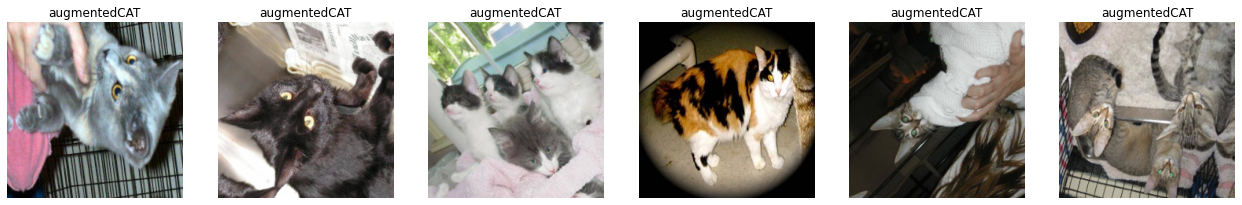

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_grid_images(images_batch, ncols=4, title=None):
  figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
  for i in range(ncols):
    axs[i].imshow(np.array(images_batch[i], dtype='int32'))
    axs[i].axis('off')
    axs[i].set_title(title[i])
show_grid_images(images_batch, ncols=6, title='augmented' + labels_batch)

In [65]:
# 원본 이미지 픽셀값의 scaling을 감안하여 다시 CnD_Dataset 수정
# Keras Sequence를 상속 받은 Dataset객체를 생성
from tensorflow.keras.utils import Sequence
import sklearn
import cv2

# 배치 크기와 이미지 크기 변수 선언
BATCH_SIZE = 64
IMAGE_SIZE = 224

class CnD_Dataset(Sequence):
  # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당
  def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False):
    '''
    image_filenames : image를 로드할 파일의 절대 경로
    labels : 해당 이미지의 label
    batch_size : __getitem__(self, index) 호출 시 마다 가져올 batch건수
    augmentor : albumentations 객체
    shuffle: 학습 데이터의 경우 epoch 종료시마다 데이타를 섞을지 여부
    '''
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.augmentor = augmentor
    self.shuffle = shuffle

  # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함.
  # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size 단위로 몇번 데이터를 반환하는지 나타냄
  def __len__(self):
    # batch_size단위로 데이터를 몇번 가져와야하는지 계산, 전체 데이터 건수를 batch_size로 나누되, 
    # 정수로 정확히 나줘 지지 않을 경우 1회를 더한다.
    return int(np.ceil(len(self.labels)/self.batch_size))

  def __getitem__(self, index):
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이터를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환

    image_name_batch = self.image_filenames[index * self.batch_size:(index+1) * self.batch_size]
    if self.labels is not None:
      label_batch = self.labels[index * self.batch_size : (index + 1) * self.batch_size]
    
    image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
    for image_index in range(image_name_batch.shape[0]):
      image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
      if self.augmentor is not None:
        image = self.augmentor(image=image)['image']
      # 이미지 픽셀 값을 0~1로 스케일링
      image = image/255.
      image_batch[image_index] = image
    return image_batch, label_batch
    
  def on_epoch_end(self):
    # epoch각 한번 수행 완료 될 때마다 모델의 fit()에서 호출 함.
    if (self.shuffle):
      self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
    else:
      pass

(64, 224, 224, 3) (64,)
[[[[0.61176471 0.66666667 0.63529412]
   [0.60392157 0.67058824 0.65490196]
   [0.6        0.67058824 0.66666667]
   ...
   [0.81176471 0.71372549 0.6627451 ]
   [0.78823529 0.65098039 0.60784314]
   [0.73333333 0.5372549  0.50980392]]

  [[0.60784314 0.66666667 0.64313725]
   [0.60784314 0.67058824 0.6627451 ]
   [0.60392157 0.6745098  0.6745098 ]
   ...
   [0.79607843 0.70588235 0.64705882]
   [0.76078431 0.63137255 0.58823529]
   [0.70588235 0.51764706 0.49803922]]

  [[0.60784314 0.66666667 0.64313725]
   [0.61960784 0.67843137 0.67058824]
   [0.60392157 0.6745098  0.6745098 ]
   ...
   [0.78431373 0.69411765 0.63529412]
   [0.75294118 0.63137255 0.58823529]
   [0.70196078 0.5254902  0.50980392]]

  ...

  [[0.58039216 0.60784314 0.55686275]
   [0.18039216 0.17254902 0.11764706]
   [0.10588235 0.10196078 0.0745098 ]
   ...
   [0.49019608 0.50196078 0.47058824]
   [0.20392157 0.20784314 0.17647059]
   [0.09411765 0.07843137 0.04705882]]

  [[0.58431373 0.6117

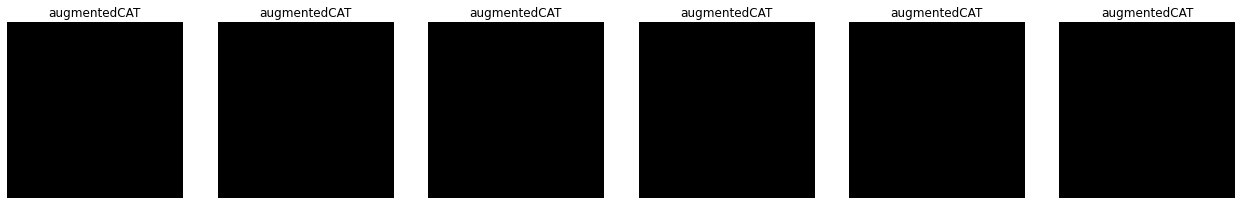

In [66]:
cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                     augmentor=cnd_augmentor, shuffle=False)
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0:2])
# show_grid_images(images_batch, ncols=6, title='augmented' + labels_batch)

In [67]:
# Pretrained 모델에서 사용하는 보다 범용적인 Preprocessing을 적용 할 수 있도록 수정
# - pre_func 인자를 추가 -> pretrained 모델의 preprocess_input 함수를 인자로 입력할 수 있도록 구성
class CnD_Dataset(Sequence):
  # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당
  def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=None):
    '''
    image_filenames : image를 로드할 파일의 절대 경로
    labels : 해당 이미지의 label
    batch_size : __getitem__(self, index) 호출 시 마다 가져올 batch건수
    augmentor : albumentations 객체
    shuffle: 학습 데이터의 경우 epoch 종료시마다 데이타를 섞을지 여부
    '''
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.augmentor = augmentor
    self.shuffle = shuffle
    self.pre_func = pre_func

  # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함.
  # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size 단위로 몇번 데이터를 반환하는지 나타냄
  def __len__(self):
    # batch_size단위로 데이터를 몇번 가져와야하는지 계산, 전체 데이터 건수를 batch_size로 나누되, 
    # 정수로 정확히 나줘 지지 않을 경우 1회를 더한다.
    return int(np.ceil(len(self.labels)/self.batch_size))

  def __getitem__(self, index):
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이터를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환

    image_name_batch = self.image_filenames[index * self.batch_size:(index+1) * self.batch_size]
    if self.labels is not None:
      label_batch = self.labels[index * self.batch_size : (index + 1) * self.batch_size]
    
    image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
    for image_index in range(image_name_batch.shape[0]):
      image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
      if self.augmentor is not None:
        image = self.augmentor(image=image)['image']
      # 이미지 픽셀 값을 0~1로 스케일링
      # image = image/255.
      if self.pre_func is not None:
        image = self.pre_func(image)
      image_batch[image_index] = image
    return image_batch, label_batch
    
  def on_epoch_end(self):
    # epoch각 한번 수행 완료 될 때마다 모델의 fit()에서 호출 함.
    if (self.shuffle):
      self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
    else:
      pass

In [68]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input

cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                     augmentor=cnd_augmentor, shuffle=False, pre_func=xcp_preprocess_input)
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0:1])

(64, 224, 224, 3) (64,)
[[[[ 0.39607847 -0.08235294 -0.02745098]
   [ 0.30196083 -0.15294117 -0.17647058]
   [ 0.45098042  0.11372554  0.00392163]
   ...
   [ 0.23921573  0.24705887  0.20000005]
   [-0.12156862 -0.05098039 -0.05098039]
   [-0.80392158 -0.65490198 -0.58431375]]

  [[ 0.38823533 -0.08235294 -0.02745098]
   [ 0.29411769 -0.1607843  -0.18431371]
   [ 0.4039216   0.06666672 -0.03529412]
   ...
   [ 0.27058828  0.27843142  0.23137259]
   [-0.12156862 -0.04313725 -0.05098039]
   [-0.81176472 -0.65490198 -0.59215689]]

  [[ 0.38823533 -0.08235294 -0.01960784]
   [ 0.27058828 -0.1607843  -0.20784312]
   [ 0.36470592  0.02745104 -0.09803921]
   ...
   [ 0.28627455  0.29411769  0.24705887]
   [-0.09803921 -0.04313725 -0.04313725]
   [-0.80392158 -0.67058825 -0.60784316]]

  ...

  [[-0.99215686 -0.99215686 -1.        ]
   [-0.97647059 -0.96862745 -0.95294118]
   [-0.97647059 -0.97647059 -0.96078432]
   ...
   [-0.09803921 -0.01960784 -0.00392157]
   [ 0.23137259  0.30196083  0.27

In [70]:
# 별도의 preprocessing함수나 Albumentations의 Normalize 적용 해 보기
def zero_one_scaler(image):
  return image/255.

cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                     augmentor=cnd_augmentor, shuffle=False, pre_func=zero_one_scaler)
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0:1])

(64, 224, 224, 3) (64,)
[[[[0.87843137 0.72156863 0.64705882]
   [0.8745098  0.71764706 0.63921569]
   [0.85098039 0.68627451 0.62352941]
   ...
   [0.45098039 0.49019608 0.46666667]
   [0.09411765 0.17254902 0.16862745]
   [0.63921569 0.74117647 0.70588235]]

  [[0.87058824 0.71372549 0.63529412]
   [0.8745098  0.70196078 0.62745098]
   [0.83921569 0.66666667 0.6       ]
   ...
   [0.39607843 0.43529412 0.41960784]
   [0.15294118 0.22745098 0.22352941]
   [0.64705882 0.74117647 0.72156863]]

  [[0.86666667 0.70588235 0.62352941]
   [0.85882353 0.68627451 0.60392157]
   [0.81568627 0.63921569 0.56862745]
   ...
   [0.38823529 0.42745098 0.41176471]
   [0.21176471 0.28235294 0.28235294]
   [0.61176471 0.69019608 0.67843137]]

  ...

  [[0.02352941 0.         0.00392157]
   [0.01960784 0.00392157 0.01568627]
   [0.01568627 0.00392157 0.03137255]
   ...
   [0.2        0.28235294 0.26666667]
   [0.31372549 0.4        0.38431373]
   [0.58431373 0.63921569 0.60784314]]

  [[0.01960784 0.    

In [71]:
# 별도의 preprocessing함수나 Albumentations의 Normalize 적용 해 보기
cnd_augmentor = A.Compose([
                         A.HorizontalFlip(p=0.5),
                         A.VerticalFlip(p=0.5),
                         A.ShiftScaleRotate(p=0.5),
                         A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                        ])

cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                     augmentor=cnd_augmentor, shuffle=False, pre_func=None)
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0:1])

(64, 224, 224, 3) (64,)
[[[[-1.91240692 -1.89565814 -1.68244004]
   [-1.91240692 -1.82563007 -1.56043565]
   [-1.98090589 -1.89565814 -1.63015246]
   ...
   [-0.16568205  0.13515407  0.39163399]
   [ 0.67343086  0.95798314  1.12366009]
   [ 0.17681302  0.3277311   0.35677561]]

  [[-2.01515532 -1.96568608 -1.76958597]
   [-2.0836544  -2.01820707 -1.75215685]
   [-2.10077929 -2.01820707 -1.75215685]
   ...
   [-0.18280679  0.10014007  0.35677561]
   [ 0.67343086  0.95798314  1.12366009]
   [ 0.19393778  0.36274511  0.37420481]]

  [[-2.10077929 -2.01820707 -1.80444443]
   [-2.06652975 -1.96568608 -1.69986928]
   [-2.06652975 -1.98319316 -1.71729839]
   ...
   [-0.14855729  0.15266107  0.40906319]
   [ 0.57068235  0.87044817  1.01908493]
   [ 0.10831401  0.2577031   0.28705883]]

  ...

  [[ 0.91317743  0.01260506  0.37420481]
   [ 0.65630615 -0.16246496 -0.04409584]
   [ 0.86180317  0.2577031   0.19991288]
   ...
   [ 0.69055563  0.85294116  0.96679741]
   [-0.14855729  0.10014007  0.32

In [73]:
# 학습, 검증 데이터 분할 및 레이블 인코딩 적용
pd.factorize(train_df['label'])[0].shape
pd.factorize(train_df['label'])[0]

array([0, 0, 0, ..., 1, 1, 1])

In [74]:
pd.get_dummies(train_df['label']).values

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

In [76]:
labels_ohe = pd.get_dummies(train_df['label']).values
print(labels_ohe[:5])
labels_enc = pd.factorize(train_df['label'])[0]
print(labels_enc[:5])
print(labels_ohe.shape, labels_enc.shape)

[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
[0 0 0 0 0]
(8005, 2) (8005,)


In [77]:
from sklearn.model_selection import train_test_split

# 학습 데이터와 테스트 데이터용 Dataframe 생성
train_df = data_df[data_df['dataset'] == 'train']
test_df = data_df[data_df['dataset'] == 'test']

# 학습 데이터의 image path와 label을 numpy array로 변환 및 Label encoding
train_path = train_df['path'].values
train_label = pd.factorize(train_df['label'])[0]

tr_path, val_path, tr_label, val_label = train_test_split(train_path, train_label, test_size=0.15, random_state=10)

print('학습용 path shape: ', tr_path.shape, ' 검증용 path shape: ', val_path.shape, 
      '학습용 label shape: ', tr_label.shape, ' 검증용 label shape: ', val_label.shape)

학습용 path shape:  (6804,)  검증용 path shape:  (1201,) 학습용 label shape:  (6804,)  검증용 label shape:  (1201,)


In [78]:
cnd_augmentor = A.Compose([
                         A.HorizontalFlip(p=0.5),
                        #  A.VerticalFlip(p=0.5),
                        #  A.ShiftScaleRotate(p=0.5),
                        #  A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                        ])

In [80]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input

tr_ds = CnD_Dataset(tr_path, tr_label, batch_size=BATCH_SIZE, 
                     augmentor=cnd_augmentor, shuffle=False, pre_func=xcp_preprocess_input)
val_ds = CnD_Dataset(val_path, val_label, batch_size=BATCH_SIZE, 
                     augmentor=cnd_augmentor, shuffle=False, pre_func=xcp_preprocess_input)


tr_image_batch = next(iter(tr_ds))[0]
val_image_batch = next(iter(val_ds))[0]
print(tr_image_batch.shape, val_image_batch.shape)
print(tr_image_batch[0:1])
print(val_image_batch[0:1])

(64, 224, 224, 3) (64, 224, 224, 3)
[[[[0.12941182 0.11372554 0.15294123]
   [0.09803927 0.082353   0.12156868]
   [0.082353   0.06666672 0.10588241]
   ...
   [0.36470592 0.35686278 0.34117651]
   [0.36470592 0.35686278 0.34117651]
   [0.36470592 0.36470592 0.34901965]]

  [[0.12156868 0.10588241 0.14509809]
   [0.082353   0.06666672 0.10588241]
   [0.07450986 0.05882359 0.09803927]
   ...
   [0.38039219 0.37254906 0.35686278]
   [0.38039219 0.37254906 0.35686278]
   [0.38039219 0.38039219 0.36470592]]

  [[0.10588241 0.09019613 0.12941182]
   [0.07450986 0.05882359 0.09803927]
   [0.05882359 0.04313731 0.082353  ]
   ...
   [0.37254906 0.36470592 0.34901965]
   [0.38039219 0.37254906 0.35686278]
   [0.38039219 0.38039219 0.36470592]]

  ...

  [[0.11372554 0.22352946 0.43529415]
   [0.13725495 0.24705887 0.45882356]
   [0.1686275  0.27843142 0.48235297]
   ...
   [0.27058828 0.36470592 0.47450984]
   [0.27843142 0.37254906 0.48235297]
   [0.27843142 0.37254906 0.48235297]]

  [[0.160

In [138]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception, MobileNetV2

def create_model(model_name='vgg16', verbose=False):
  input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
  if model_name == 'vgg16':
    base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
  elif model_name == 'resnet50':
    base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
  elif model_name == 'xception':
    base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
  elif model_name == 'mobilenet':
    base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')
  bm_output = base_model.output
  x = GlobalAveragePooling2D()(bm_output)
  if model_name != 'vgg16':
    x = Dropout(rate=0.5)(x)
  x = Dense(50, activation='relu', name='fc1')(x)
  output = Dense(1, activation='sigmoid', name='output')(x)
  model = Model(inputs=input_tensor, outputs=output)
  if verbose:
    model.summary()
  return model


In [139]:
import tensorflow as tf
tf.keras.backend.clear_session()
model = create_model(model_name='xception')
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [140]:
# 3번 iteration 내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2 로 줄임
# ReduceLRONPlateau 콜백
# 이 콜백을 사용하면 검증 손실이 향상되지 않을 때 학습률을 작게 할 수 있습니다. 
# 손실 곡선이 평탄할 때 학습률을 작게 하거나 크게 하면 훈련 도중 지역 최솟값에서 효과적으로 빠져나올 수 있습니다.
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)

# 5번 iteration내에 validation loss가 향상되지 않으면 더이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

In [ ]:
N_EPOCHS = 15
history = model.fit(tr_ds, epochs=N_EPOCHS,
                    steps_per_epoch = int(np.ceil(tr_path.shape[0]/BATCH_SIZE)),
                    validation_data=val_ds,
                    validation_steps = int(np.ceil(val_path.shape[0]/BATCH_SIZE)),
                    callbacks=([rlr_cb, ely_cb]), verbose=1
                    )

In [92]:
# 테스트용 Dataset 생성 후 성능 평가
test_df = data_df[data_df['dataset']=='test']
test_path = test_df['path'].values
test_label = pd.factorize(test_df['label'])[0]
test_ds = CnD_Dataset(test_path, test_label, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=xcp_preprocess_input)
model.evaluate(test_ds)

32/32 [==============================] - 11s 324ms/step - loss: 0.0623 - accuracy: 0.9807


[0.0622892789542675, 0.9807217121124268]

In [143]:
# 여러 Pretrained 모델을 이용하여 성능 평가
def get_train_valid_test(data_df):
  # 학습 데이터와 테스트 데이터용 Dataframe 생성.
  train_df = data_df[data_df['dataset'] == 'train']
  test_df = data_df[data_df['dataset'] == 'test']
  # 학습 데이터의 image path와 label을 numpy array로 변환 및 label encoding
  train_path = train_df['path'].values
  train_label = pd.factorize(train_df['label'])[0]
  test_path = test_df['path'].values
  test_label = pd.factorize(test_df['label'])[0]
  # 학습데이터를 훈련용, 검증용 나누기
  tr_path, val_path, tr_label, val_label = train_test_split(train_path, train_label, test_size=0.15, random_state=10)
  return tr_path, tr_label, val_path, val_label, test_path, test_label


In [144]:
def do_train_evaluation(data_df, model_name, augmentor, preprocessing_func):
  #학습/검증/테스트 이미지 파일 절대 경로와 Label encoding 된 데이터 셋 만들기
  tr_path, tr_label, val_path, val_label, test_path, test_label = get_train_valid_test(data_df)

  # 학습과 검증용 Sequence Datatset 생성
  tr_ds = CnD_Dataset(tr_path, tr_label, batch_size=BATCH_SIZE, augmentor=augmentor, 
                      shuffle=True, pre_func=preprocessing_func)
  val_ds = CnD_Dataset(val_path, val_label, batch_size=BATCH_SIZE, augmentor=augmentor, 
                       shuffle=False, pre_func=preprocessing_func)
  # 입력된 model_name에 따라 모델 생성
  model = create_model(model_name=model_name)
  # 최종 output 출력을 softmax에서 sigmoid로 변환 되었으므로 binary_crossentropy로 변환
  model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

  # 3번 iteration 내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2 로 줄임
  rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
  # 5번 iteration내에 validation loss가 향상되지 않으면 더이상 학습하지 않고 종료
  ely_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

  N_EPOCHS = 15
  # # 학습 수행
  history = model.fit(tr_ds, epochs=N_EPOCHS,
                      steps_per_epoch=int(np.ceil(tr_path.shape[0]/BATCH_SIZE)),
                      validation_data=val_ds,
                      validation_steps=int(np.ceil(val_path.shape[0]/BATCH_SIZE)),
                      callbacks=([rlr_cb, ely_cb]), verbose=1
                      )
  # # 테스트용 Sequence Dataset 생성 후 evaluation 수행
  test_ds = CnD_Dataset(test_path, test_label, batch_size=BATCH_SIZE, augmentor=None, 
                        shuffle=None, pre_func=preprocessing_func)
  evaluation_result = model.evaluate(test_ds)
  return history, evaluation_result

In [145]:
# MobileNet 모델 성능 평가
from tensorflow.keras.applications.mobilenet import preprocess_input as mobile_preprocess_input
tf.keras.backend.clear_session()
cnd_augmentor1 = A.Compose([
                            A.HorizontalFlip(p=0.3),
                            A.ShiftScaleRotate(p=0.2),
                            A.RandomBrightnessContrast(p=0.2)
                ])
history_mobile, result_mobile = do_train_evaluation(data_df, 'mobilenet', cnd_augmentor1, mobile_preprocess_input)

Epoch 1/15
107/107 [==============================] - 93s 453ms/step - loss: 0.1336 - accuracy: 0.9456 - val_loss: 1.7089 - val_accuracy: 0.8726
Epoch 2/15
107/107 [==============================] - 47s 437ms/step - loss: 0.0893 - accuracy: 0.9643 - val_loss: 1.1355 - val_accuracy: 0.8585
Epoch 3/15
107/107 [==============================] - 48s 445ms/step - loss: 0.0831 - accuracy: 0.9684 - val_loss: 3.6313 - val_accuracy: 0.7702
Epoch 4/15
107/107 [==============================] - 48s 447ms/step - loss: 0.0667 - accuracy: 0.9768 - val_loss: 2.0928 - val_accuracy: 0.8177
Epoch 5/15
107/107 [==============================] - 48s 446ms/step - loss: 0.0542 - accuracy: 0.9799 - val_loss: 1.5219 - val_accuracy: 0.8285

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/15
107/107 [==============================] - 48s 449ms/step - loss: 0.0316 - accuracy: 0.9878 - val_loss: 0.6673 - val_accuracy: 0.9092
Epoch 7/15
107/107 [============================

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobile_preprocess_input
tf.keras.backend.clear_session()
cnd_augmentor2 = A.Compose([
                            A.HorizontalFlip(p=0.3),
                            A.ColorJitter(p=0.2),
                            A.CLAHE(p=0.2),
                            A.Cutout(p=0.2)
                ])
history_mobile, result_mobile = do_train_evaluation(data_df, 'mobilenet', cnd_augmentor2, mobile_preprocess_input)

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobile_preprocess_input
tf.keras.backend.clear_session()
cnd_augmentor3 = A.Compose([
                            A.HorizontalFlip(p=0.3)
                ])
history_mobile, result_mobile = do_train_evaluation(data_df, 'mobilenet', cnd_augmentor3, mobile_preprocess_input)

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobile_preprocess_input
tf.keras.backend.clear_session()
cnd_augmentor3 = A.Compose([
                            A.HorizontalFlip(p=0.3)
                ])
history_mobile, result_mobile = do_train_evaluation(data_df, 'vgg16', cnd_augmentor3, mobile_preprocess_input)

In [ ]:
# Pretrained 모델에 Fine Tuning 적용
